## 0. Imports

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import ConfusionMatrixDisplay

# Varios
# ==============================================================================
import sys
sys.path.append("..")
import src.support as sp
from scipy.sparse import csr_matrix
import pickle
import warnings
warnings.filterwarnings("ignore")

## 1. División del conjunto de datos

In [100]:
df = pd.read_pickle("../data/clean")
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [101]:
df = df[df["foreign_worker"] == "yes"]

In [102]:
train_set, val_set, test_set = sp.train_val_test_split(df)
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 577
Longitud del Validation Set: 193
Longitud del Test Set: 193


In [103]:
X_train, y_train = sp.remove_labels(train_set, "class")
X_val, y_val = sp.remove_labels(val_set, "class")
X_test, y_test = sp.remove_labels(test_set, "class")

## 2. Preparación del conjunto de datos

In [104]:
num_attribs = list(X_train.select_dtypes(exclude=['object']))
cat_attribs = list(X_train.select_dtypes(include=['object']))

In [105]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rbst_scaler", RobustScaler())
])

In [106]:
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.encoders[col] = le
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders[col].transform(X[col])
        return X_copy


In [107]:
cat_pipeline = Pipeline([("oh", OneHotEncoder())])

In [108]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [109]:
X_train_prep = full_pipeline.fit_transform(X_train)
sparse_matrix = csr_matrix(X_train_prep)
X_train_prep = pd.DataFrame.sparse.from_spmatrix(
    sparse_matrix, 
    columns=list(pd.get_dummies(X_train)), 
    index=X_train.index
)

In [110]:
le = LabelEncoder()
y_train_prep = le.fit_transform(y_train)

## 3. Entrenamiento del algoritmo

In [111]:
log_reg = LogisticRegression(C=1000)

In [112]:
log_reg.fit(X_train_prep, y_train)

LogisticRegression(C=1000)

In [113]:
df = pd.DataFrame(pd.Series(log_reg.coef_[0]))
df.sort_values(by=0, ascending=False)

,0
20,1.629927
6,1.585111
41,1.237159
63,0.970340
25,0.958113
...,...
23,-0.790893
4,-0.846778
19,-0.915041
7,-1.199648


In [114]:
pickle.dump(log_reg, open("modelo_regresion_lineal.sav", "wb"))

## 4. Predicciones

In [115]:
y_train_pred = log_reg.predict(X_train_prep)
y_train_pred_prep = le.transform(y_train_pred)

In [116]:
X_val_prep = full_pipeline.transform(X_val)
sparse_matrix_prep = csr_matrix(X_val_prep)
X_val_prep = pd.DataFrame.sparse.from_spmatrix(sparse_matrix_prep, columns=list(pd.get_dummies(X_train)), index=X_val.index)

In [117]:
y_val_pred = log_reg.predict(X_val_prep)
y_val_pred_prep = le.transform(y_val_pred)

## 5. Evaluación de resultados

In [118]:
scores_v2 = cross_validate(log_reg, X_train_prep, y_train, cv=5, scoring=["f1_weighted", "accuracy"])
scores_v2

{'fit_time': array([0.01608944, 0.01714563, 0.01389599, 0.01418853, 0.0178287 ]),
 'score_time': array([0.00411034, 0.00333285, 0.00242996, 0.        , 0.0059979 ]),
 'test_f1_weighted': array([0.78509852, 0.80515164, 0.71418105, 0.79057135, 0.7597446 ]),
 'test_accuracy': array([0.79310345, 0.81034483, 0.72173913, 0.8       , 0.76521739])}

In [119]:
y_pred = cross_val_predict(log_reg, X_train_prep, y_train, cv=10)

In [120]:
metrics.f1_score(y_train, y_pred, average='weighted', pos_label='bad')

0.7602592326365326

In [121]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_v2["test_f1_weighted"].mean(), scores_v2["test_f1_weighted"].std()))

0.77 accuracy with a standard deviation of 0.03


In [122]:
y_val_prep = le.transform(y_val)

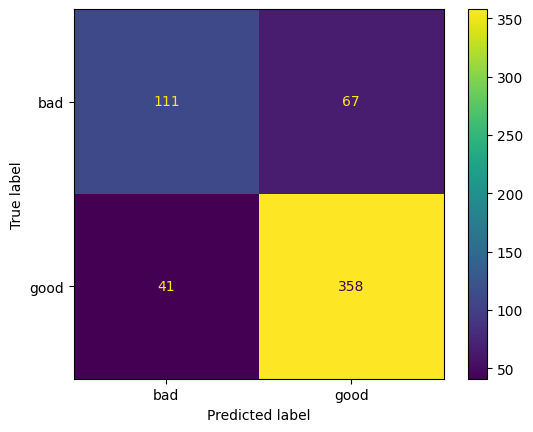

In [123]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_train_prep, y_train)

In [124]:
print("Accuray:", metrics.accuracy_score(y_val, y_val_pred))
print("Precision:", metrics.precision_score(y_val, y_val_pred, pos_label="bad"))
print("Recall:", metrics.recall_score(y_val, y_val_pred, pos_label='bad', average="weighted"))
print("F1 score:", metrics.f1_score(y_val, y_val_pred, pos_label='bad', average='weighted'))

Accuray: 0.7409326424870466
Precision: 0.5882352941176471
Recall: 0.7409326424870466
F1 score: 0.7352666106890031


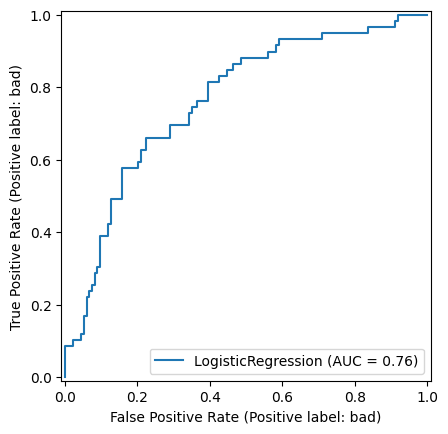

In [125]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(log_reg, X_val_prep, y_val, pos_label="bad")

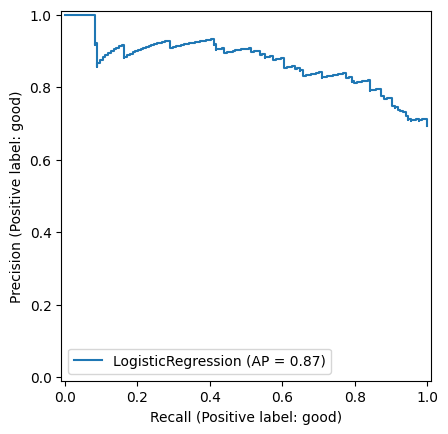

In [126]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(log_reg, X_val_prep, y_val)

## 8. Explicabilidad del modelo

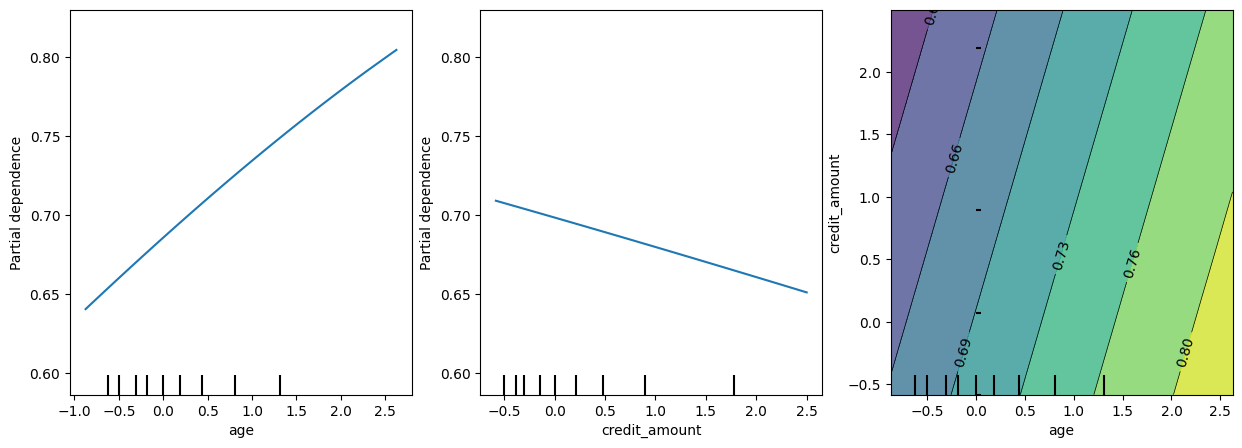

In [127]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
disp1 = PartialDependenceDisplay.from_estimator(log_reg, X_train_prep, ["age", "credit_amount", ("age", "credit_amount")], ax=ax);